In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import random

from tqdm import tqdm

In [2]:
colnames = ["sex", "length", "diameter", "height", "whole_weight", \
        "shucked_weight", "viscera_weight", "shell_weight", "rings"]
dataset = pd.read_csv("data/abalone.data", names=colnames)

In [3]:
dataset = dataset.sample(n=1_000)

In [4]:
X = dataset.drop(columns='rings')
y = dataset['rings']

Discretizamos la variable objetivo y convertimos el problema de regresión en clasificación binaria.

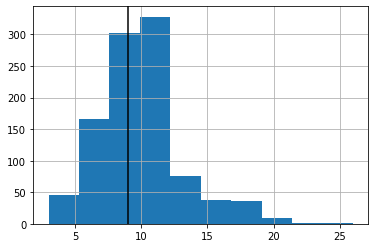

In [5]:
y.hist()
plt.axvline(y.median(), color='black')

In [6]:
y_categ = (dataset['rings'] < dataset['rings'].mean()).astype(int)

El problema resultante está equilibrado como se puede ver a continuación.

In [7]:
y_categ.value_counts()

1    513
0    487
Name: rings, dtype: int64

# Creación de un árbol de decisión

[![Árbol de decisión](https://static.javatpoint.com/tutorial/machine-learning/images/decision-tree-classification-algorithm.png)](https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm)

Para facilitar la implementación del árbol, vamos a utilizar una implementación basada en OOP. La clase base sera Node, que representará un nodo (hoja, split) de nuestro árbol.

In [8]:
class Node:
    
    def predict(self, sample):
        raise NotImplemented
    
    def pprint(self, level=0):
        raise NotImplemented

Una hoja es un nodo terminal, y su predicción será siempre la misma (las probabilidades de la partición con la que se genero).

In [9]:
class Leaf(Node):
    
    def __init__(self, probs):
        super().__init__()
        self.probs = probs
        
    def predict(self, sample):
        return self.probs
    
    def pprint(self, level=0):
        pad = '| ' + '--' * level
        return '{} {}\n'.format(pad, round(self.probs, 2).to_dict())

Por último creamos otro tipo de Nodo que representará un split numérico y otro que será categórico.

In [10]:
class NumericalSplit(Node):
    
    def __init__(self, feature, value, left_child, right_child):
        super().__init__()
        self.feature = feature
        self.value = value
        self.left_child = left_child
        self.right_child = right_child
        
    def predict(self, sample):
        child = self.left_child if sample[self.feature] <= self.value else self.right_child
        return child.predict(sample)
    
    def pprint(self, level=0):
        pad = '| ' + '--' * level
        left_pprint = pad + 'if {} <= {}:\n'.format(self.feature, self.value) + self.left_child.pprint(level + 1)
        right_pprint = pad + 'if {} > {}:\n'.format(self.feature, self.value) + self.right_child.pprint(level + 1)
        return left_pprint + right_pprint
    
    
class CategoricalSplit(Node):
    
    def __init__(self, feature, value, left_child, right_child):
        super().__init__()
        self.feature = feature
        self.value = value
        self.left_child = left_child
        self.right_child = right_child
        
    def predict(self, sample):
        child = self.left_child if sample[self.feature] == self.value else self.right_child
        return child.predict(sample)
        
    def pprint(self, level=0):
        super().__init__()
        pad = '| ' + '--' * level
        left_pprint = pad + 'if {} == {}:\n'.format(self.feature, self.value) + self.left_child.pprint(level + 1)
        right_pprint = pad + 'if {} != {}:\n'.format(self.feature, self.value) + self.right_child.pprint(level + 1)
        return left_pprint + right_pprint

Probamos un ejemplo..

In [11]:
dt = NumericalSplit(
                    'age',
                    10,
                    CategoricalSplit(
                                    'education',
                                    'high-school',
                                     Leaf(pd.Series([0.1, 0.9], index=['0', '1'])),
                                     Leaf(pd.Series([0.6, 0.4], index=['0', '1'])),
                    ),
                    Leaf(pd.Series([1, 0], index=['0', '1'])),
)

In [12]:
print(dt.pprint())

| if age <= 10:
| --if education == high-school:
| ---- {'0': 0.1, '1': 0.9}
| --if education != high-school:
| ---- {'0': 0.6, '1': 0.4}
| if age > 10:
| -- {'0': 1, '1': 0}



In [13]:
dt.predict({'age': 11})

0    1
1    0
dtype: int64

In [14]:
dt.predict({'age': 10, 'education': 'high-school'})

0    0.1
1    0.9
dtype: float64

In [15]:
dt.predict({'age': 10, 'education': None})

0    0.6
1    0.4
dtype: float64

# ¿Y cómo hacemos que esto sea machine-learning y no human-learning?

Algoritmo de construcción de un árbol de decisión. Repetimos el siguiente proceso de división del dataset.

* 1) Si la condición de parada se cumple. Creamos una regla siguiendo A).
* 2) Si no se cumple, buscamos la mejor forma de partir del dataset. De esta forma obtenemos dos particiones.
* 3) Volvemos al paso 1) con cada una de las particiones.

A) Regla: Conjunto de condiciones actuales. La predicción se calcula como la frecuencia relativa de las clases de las observaciones en esa regla.

## ¿Cómo calculamos la probabilidad?

Para calcular la probabilidad a priori de un conjunto de observaciones, podemos calcular la frecuencia relativa de sus etiquetas.

In [16]:
def partition_prob(partition, y):
    probs = pd.value_counts(y[partition]) / len(partition)
    return probs.sort_index()

In [17]:
partition_prob(X.index, y_categ)

0    0.487
1    0.513
Name: rings, dtype: float64

## ¿Cómo evaluamos un splits?

In [18]:
def gini_index(idx, y):
    probs = partition_prob(idx, y)
    return 1 - (probs * probs).sum()

def gini_gain(left_partition_idxs, right_partition_idxs, y):
    n_instances = len(left_partition_idxs) + len(right_partition_idxs)
    
    gini_initial = gini_index(list(left_partition_idxs) + list(right_partition_idxs), y)
    
    gini_left = gini_index(left_partition_idxs, y)
    gini_right = gini_index(right_partition_idxs, y)
    

    left_proportion = len(left_partition_idxs) / n_instances
    right_proportion = len(right_partition_idxs) / n_instances
    
    return gini_initial - gini_left * left_proportion - gini_right * right_proportion

In [19]:
gini_gain(X.index[:2000], X.index[2000:], y_categ)

0.0

In [20]:
gini_gain([0, 1, 2], [3, 4, 5], np.array([0, 1, 0, 1, 0, 1]))

0.05555555555555558

In [21]:
gini_gain([0, 1, 2], [3, 4, 5], np.array([0, 0, 0, 1, 1, 1]))

0.5

## ¿Qué split cogemos?

### Variables numericas

In [22]:
def numeric_split_scores(feature, y):
    unique_values = sorted(feature.unique())
    
    cut_values = []
    gini_values = []
    
    for value in unique_values[:-1]:
        left_partition = feature[feature <= value]
        right_partition = feature[feature > value]
        gain = gini_gain(left_partition.index, right_partition.index, y)
        gini_values.append(gain)
        cut_values.append(value)
    
    return cut_values, gini_values

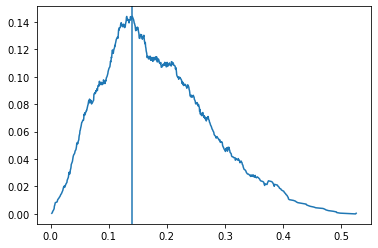

In [23]:
cut_values, gini_values = numeric_split_scores(X['viscera_weight'], y_categ)
plt.plot(cut_values, gini_values)
plt.axvline(cut_values[np.argmax(gini_values)])

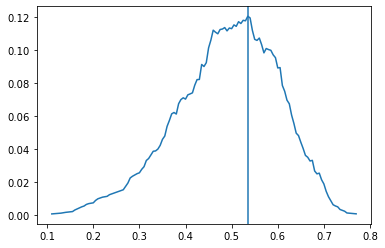

In [24]:
cut_values, gini_values = numeric_split_scores(X['length'], y_categ)
plt.plot(cut_values, gini_values)
plt.axvline(cut_values[np.argmax(gini_values)])

### Variables categoricas

In [25]:
def categorical_split_scores(feature, y):
    unique_values = sorted(feature.unique())
    
    cut_values = []
    gini_values = []
    
    for value in unique_values:
        left_partition = feature[feature == value]
        right_partition = feature[feature != value]
        gini = gini_gain(left_partition.index, right_partition.index, y)
        
        gini_values.append(gini)
        cut_values.append(value)
    
    return cut_values, gini_values

In [26]:
X['sex'].unique()

array(['F', 'I', 'M'], dtype=object)

In [27]:
cut_values, gini_values = categorical_split_scores(X['sex'], y_categ)
pd.DataFrame(data={'value': cut_values, 'gini_value': gini_values}).round(3)

,value,gini_value
0,F,0.034
1,I,0.120
2,M,0.027


## Seleccionar el mejor split

Primero calculamos el mejor split de cada feature dependiendo de su tipo

In [28]:
def best_feature_split(feature, y):
    if is_string_dtype(feature):
        cut_values, gini_values = categorical_split_scores(feature, y)
        split_type = 'categorical'
    else:
        cut_values, gini_values =  numeric_split_scores(feature, y)
        split_type = 'numerical'
        
    if len(cut_values) == 0:
        return None
    else:
        best_idx = np.argmin(gini_values)
        return cut_values[best_idx], gini_values[best_idx], split_type

Probamos con una variable categorica y una numérica

In [29]:
best_feature_split(X['sex'], y_categ)

('M', 0.027069521464492874, 'categorical')

In [30]:
best_feature_split(X['length'], y_categ)

(0.11, 0.0004748128128128637, 'numerical')

Ahora hacemos un método que seleccione el mejor split de entre todas las features

In [31]:
def select_best_split(partition, y):
    split_scores = []
    for feature in partition.columns:
        split = best_feature_split(partition[feature], y)
        if split is not None:
            split_scores.append((feature, *split))
            
    if len(split_scores) == 0:
        return None
    else:
        return max(split_scores, key=lambda x: x[2])

El mejor split para nuestro dataset si hacemos un único corte sería el siguiente:

In [32]:
split = select_best_split(X, y_categ)
split

('sex', 'M', 0.027069521464492874, 'categorical')

Una vez tenemos el split, podemos programar un método para aplicar ese split, obteniendo dos particiones. En la partición izquierda, la condición del split se cumple, y en la derecha no (podría ser del revés).

In [33]:
def apply_split(partition, feature, value, split_type=None):
    
    if split_type is None:
        split_type = 'categorical' if is_string_dtype(partition[feature]) else 'numerical'
    
    if split_type == 'categorical':
        return partition[partition[feature] == value], partition[partition[feature] != value]
    else:
        return partition[partition[feature] <= value], partition[partition[feature] > value]

Probamos a aplicar el split que hemos calculado anteriormente

In [34]:
left_partition, right_partition = apply_split(X, split[0], split[1])

Calculamos las probabilidades de las particiones inicial, izquierda y derecha.

In [35]:
partition_prob(X.index, y_categ)

0    0.487
1    0.513
Name: rings, dtype: float64

In [36]:
partition_prob(left_partition.index, y_categ)

0    0.651652
1    0.348348
Name: rings, dtype: float64

In [37]:
partition_prob(right_partition.index, y_categ)

0    0.404798
1    0.595202
Name: rings, dtype: float64

Podemos ver que el corte aplicado consigue separar bastante bien las clases.

y si quisieramos obtener una división mas clara? Volver a aplicar el mismo procedimiento!

In [38]:
split_l2 = select_best_split(left_partition, y)
left_partition_l2, right_partition_l2 = apply_split(left_partition, split_l2[0], split_l2[1])
split_l2

('shell_weight', 0.643, 0.002892983073163299, 'numerical')

Otra vez el mejor split vuelve a ser con la misma feature. Volvemos a calcular las probabilidades de cada partición

In [39]:
partition_prob(left_partition_l2.index, y_categ)

0    0.648485
1    0.351515
Name: rings, dtype: float64

In [40]:
partition_prob(right_partition_l2.index, y_categ)

0    1.0
Name: rings, dtype: float64

Podemos comprobar que en la partición izquierda la probabilidad de la clase 0 se ha reducido aún mas, mientras que en la derecha ha aumentado un poco

# Y listo, ya podemos construir nuestro árbol

¿ Qué nos hace falta?
* Sabemos buscar el 'mejor' corte.
* Sabemos aplicar esos cortes obteniendo dos particiones
* Podemos volver a calcular cortes sobre esas particiones.
* Pero... ¿Cuando paramos?

Algunas posibles condiciones de parada:

* No se pueden hacer mas cortes porque todas las features son constantes. -> El mejor split es None
* La impureza disminuye poco... 
* La partición tiene muy pocas observaciones (esto favorece el overfitting) -> mirar el tamaño de la partición
* Maxima profundidad 

In [41]:
splitters = {
    'numerical': NumericalSplit,
    'categorical': CategoricalSplit
}

def build_tree(X, y, max_depth=3, min_samples=10, min_gain=0):
    
    def _split(partition, depth):
        curr_partition_prob = partition_prob(partition.index, y)
        
        if depth >= max_depth or len(partition) <= min_samples:
            return Leaf(curr_partition_prob)
        
        split = select_best_split(partition, y)
        gain = float('-inf') if split is None else split[2]
        
        if split is None or gain < min_gain:
            return Leaf(curr_partition_prob)
        
        feature, value, _, split_type = split
        left_partition, right_partition = apply_split(X, feature, value, split_type=split_type)
        
        left_child = _split(left_partition, depth + 1)
        right_child = _split(right_partition, depth + 1)
        
        return splitters[split_type](feature, value, left_child, right_child)
        
        
    return _split(X, 0)

In [42]:
def predict_prob(dt, X):
    return X.apply(dt.predict, axis=1)

def predict_class(dt, X):
    return np.argmax(predict_prob(dt, X).values, axis=1)

In [43]:
X_train, X_test = train_test_split(X.sample(frac=0.5), test_size=0.3)

In [44]:
dt = build_tree(X_train, y_categ, max_depth=3)

In [45]:
print(classification_report(y_categ.loc[X_test.index], predict_class(dt, X_test)))

              precision    recall  f1-score   support

           0       0.52      0.34      0.42        64
           1       0.61      0.77      0.68        86

    accuracy                           0.59       150
   macro avg       0.57      0.56      0.55       150
weighted avg       0.57      0.59      0.57       150



In [46]:
print(dt.pprint())

| if sex == M:
| --if length <= 0.745:
| ----if sex == M:
| ------ {0: 0.67, 1: 0.33}
| ----if sex != M:
| ------ {0: 0.4, 1: 0.6}
| --if length > 0.745:
| ---- {0: 1.0}
| if sex != M:
| --if sex == F:
| ----if height <= 0.21:
| ------ {0: 0.49, 1: 0.51}
| ----if height > 0.21:
| ------ {0: 0.9, 1: 0.1}
| --if sex != F:
| ----if sex == I:
| ------ {0: 0.13, 1: 0.87}
| ----if sex != I:
| ------ {0: 0.68, 1: 0.32}



# Random Forest

In [50]:
def create_basic_rf(X, y, max_depth=3, min_samples=10, min_gain=0, n_estimators=5):
    dt = [build_tree(X, y, max_depth=max_depth, min_samples=min_samples, min_gain=min_gain) for n in tqdm(range(n_estimators))]
    return dt

In [51]:
def predict_rf_prob(dts, X):
    base = predict_prob(dts[0], X)
    for dt in dts[1:]:
        base += predict_prob(dt, X)
        
    return base / len(dts)

def predict_rf_class(dts, X):
    return np.argmax(predict_rf_prob(dts, X).values, axis=1)

In [52]:
rf = create_basic_rf(X, y_categ, max_depth=1)

100%|██████████| 5/5 [01:14<00:00, 14.95s/it]


In [53]:
y_hat = predict_rf_class(rf, X_test)

In [54]:
print(classification_report(y_categ.loc[X_test.index], predict_rf_class(rf, X_test)))

              precision    recall  f1-score   support

           0       0.52      0.34      0.42        64
           1       0.61      0.77      0.68        86

    accuracy                           0.59       150
   macro avg       0.57      0.56      0.55       150
weighted avg       0.57      0.59      0.57       150



In [55]:
print(classification_report(y_categ.loc[X_test.index], predict_class(rf[0], X_test)))

              precision    recall  f1-score   support

           0       0.52      0.34      0.42        64
           1       0.61      0.77      0.68        86

    accuracy                           0.59       150
   macro avg       0.57      0.56      0.55       150
weighted avg       0.57      0.59      0.57       150

